# Covariates, Comorbidity, additional analyses

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from scipy import stats
from statannot import add_stat_annotation
import joblib
import pingouin as pg

from importlib import reload
import sys
import os
sys.path.insert(1,'../')
import plots

/scratch/c.c21013066/docker/envs/pythonstats/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()
data_path = '/scratch/c.c21013066/data/ukbiobank/sample/withGP/noOsteo/'
acc_path = '/scratch/c.c21013066/data/ukbiobank/phenotypes/accelerometer/'

In [4]:
dfs_new = pd.read_csv(f'{acc_path}unmatched_all_HCnoOsteo.csv',index_col=0)
subset = ['AllCauseDementia','AlzheimerDisease','AllCauseParkinsonism','ParkinsonDisease','Dystonia','Osteoarthritis','Depression']

In [7]:
dfs_new.groupby('diagnosis')['Status'].value_counts()

diagnosis             Status   
AllCauseDementia      Diseased       986
                      Prodromal      383
AllCauseParkinsonism  Diseased       308
                      Prodromal      211
AlzheimerDisease      Prodromal      153
                      Diseased        59
Depression            Diseased      9514
                      Prodromal       72
Dystonia              Diseased        81
Healthy               Healthy      43753
Osteoarthritis        Diseased     12305
                      Prodromal     1102
ParkinsonDisease      Diseased       273
                      Prodromal      196
Name: Status, dtype: int64

# Comorbidity

In [8]:
cooccurances = pd.DataFrame(columns=subset,index=subset)
for disease in subset:
    for codisease in subset:
        d1 = set(dfs_new.loc[np.logical_and(dfs_new['diagnosis']==disease,dfs_new['Status'].isin(['Prodromal','Diseased']))].index.values)
        d2 = set(dfs_new.loc[np.logical_and(dfs_new['diagnosis']==codisease,dfs_new['Status'].isin(['Prodromal','Diseased']))].index.values)
        cooccurances.loc[disease,codisease] = len(d1.intersection(d2))

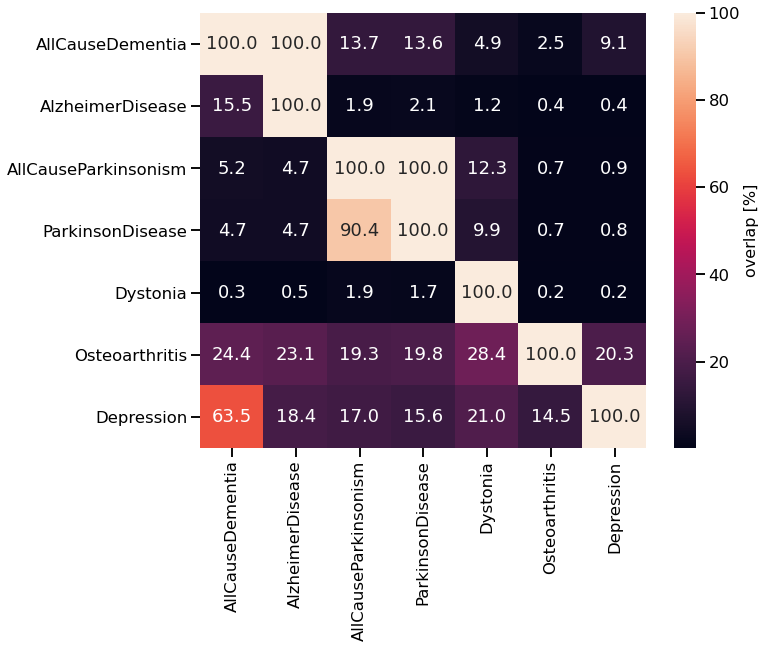

In [11]:
norm = (cooccurances / np.diag(cooccurances))*100
fig = plt.figure(figsize=(10,8))
plots.plot_context()
sns.heatmap(norm.astype(float),cbar_kws={'label': 'overlap [%]'},annot=True,fmt='.1f')
plt.savefig(f'{image_path}/overlap_disorders_HCnoOsteo.pdf',bbox_inches='tight',dpi=300)
plt.savefig(f'{image_path}/overlap_disorders_HCnoOsteo.png',bbox_inches='tight',dpi=300)

# Risk and Blood

In [6]:
drop_healthy='nonHC'
name = 'ParkinsonDisease'

HC_clean = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/phenotypes/accelerometer/allHCnoOsteo.csv')
#hc_res = pd.read_csv(f'{acc_path}HCnoOsteo_residuals_bmi.csv',index_col=0)
#HC_clean = pd.merge(hc,hc_res[['average acceleration residual']],right_index=True,left_index=True,how='outer')

In [16]:
# check for correlation
y = 'No_wear_time_bias_adjusted_average_acceleration'
covs = np.hstack([['TownsendDeprivationIndex','BMI','Waist_Circumference','Hip_Circumference','Diastolic_BloodPressure','PulseRate',
         'BodyFat_Percentage','accelerometry_age'],HC_clean.columns[48:74]])
pearson = pd.DataFrame(columns=['n','r','CI95%','p-value','BF10','power'],index=covs)
for x in covs:
    nona = HC_clean.dropna(subset=[y,x])
    if x=='BMI' or x=='accelerometry_age':
        print(x,nona.shape[0])
        print(stats.pearsonr(nona[y], nona[x]))
    #pearson.loc[x,:] = stats.pearsonr(nona[y], nona[x])
    pearson.loc[x,:] = pg.corr(nona[y], nona[x]).values
pearson['sign'] = pearson[['p-value']]<0.05/pearson.shape[0]
pearson['sign'] = pearson['sign'].replace([True,False],['*',''])

BMI 36058
PearsonRResult(statistic=-0.14417853287427498, pvalue=9.863237467999471e-167)
accelerometry_age 43753
PearsonRResult(statistic=-0.14148319563505202, pvalue=2.121647191271175e-194)


In [17]:
pearson.loc[['BMI','accelerometry_age'],:]

,n,r,CI95%,p-value,BF10,power,sign
BMI,36058,-0.144179,"[-0.15, -0.13]",0.0,1.907e+162,1.0,*
accelerometry_age,43753,-0.141483,"[-0.15, -0.13]",0.0,7.453e+189,1.0,*


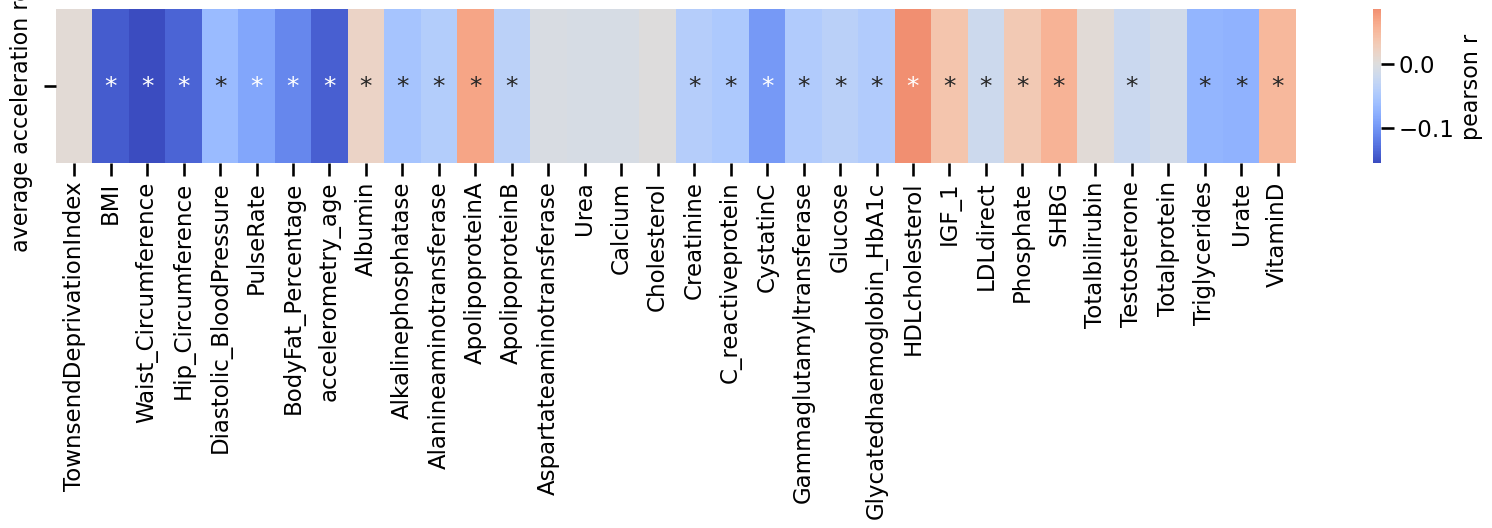

In [27]:
fig = plt.figure(figsize=(20,2))
plots.plot_context()
ax = sns.heatmap(pearson[['r']].astype(float).T,annot=pearson[['sign']].T,fmt='',cmap='coolwarm',center=0,xticklabels=True,cbar_kws={'label': 'pearson r'})
ax.set_ylabel('average acceleration residual')
ax.set_yticklabels('')
plt.savefig(f'{image_path}/heatmap_riskblood_healthyNoOsteoresid.pdf',bbox_inches='tight',dpi=200)

In [13]:
covs = ['male','AlcoholStatus_Current', 'AlcoholStatus_Previous',
       'SmokeStatus_Current', 'SmokeStatus_Previous',
       'DaytimeSleepiness_Often', 'AlcoholFrequency_LessThanWeekly',
       'family_Stroke', 'family_Diabetes', 'family_Severedepression',
       'family_Alzheimersdiseasedementia', 'family_Parkinsonsdisease']
mwu = pd.DataFrame(columns=['U-val','alternative','p-value','RBC','CLES','N_cases','N_controls','median_cases','median_controls'],index=covs)
for x in covs:
    print(x)
    cases = HC_clean.loc[HC_clean[x]==1,'No_wear_time_bias_adjusted_average_acceleration'].dropna()
    controls = HC_clean.loc[HC_clean[x]==0,'No_wear_time_bias_adjusted_average_acceleration'].dropna()
    print(cases.shape[0] + controls.shape[0])
    print(stats.mannwhitneyu(cases,controls))
    mwu.loc[x,['U-val','alternative','p-value','RBC','CLES']] = pg.mwu(cases,controls).values
    mwu.loc[x,'N_cases'] = cases.shape[0]
    mwu.loc[x,'N_controls'] = controls.shape[0]
    mwu.loc[x,'median_cases'] = cases.mean()
    mwu.loc[x,'median_controls'] = controls.mean()

male
43753
MannwhitneyuResult(statistic=215370366.0, pvalue=2.9379519157156674e-65)
AlcoholStatus_Current
36058
MannwhitneyuResult(statistic=29547249.5, pvalue=0.08419480878078085)
AlcoholStatus_Previous
36058
MannwhitneyuResult(statistic=12001102.0, pvalue=0.010923130226158902)
SmokeStatus_Current
36058
MannwhitneyuResult(statistic=28502855.5, pvalue=0.0018037888220613985)
SmokeStatus_Previous
36058
MannwhitneyuResult(statistic=141941632.0, pvalue=1.9659549836033294e-05)
DaytimeSleepiness_Often
36058
MannwhitneyuResult(statistic=10754576.5, pvalue=0.6430518895332313)
AlcoholFrequency_LessThanWeekly
36058
MannwhitneyuResult(statistic=111402810.0, pvalue=1.583968636854644e-09)
family_Stroke
36058
MannwhitneyuResult(statistic=63472270.0, pvalue=1.5807068602461514e-05)
family_Diabetes
36058
MannwhitneyuResult(statistic=99894580.0, pvalue=0.012607667337066452)
family_Severedepression
36058
MannwhitneyuResult(statistic=75215500.0, pvalue=0.0013446522344927726)
family_Alzheimersdiseasedement

In [11]:
mwu

,U-val,alternative,p-value,RBC,CLES,N_cases,N_controls,median_cases,median_controls
male,215370366.0,two-sided,0.0,0.094466,0.452767,20172,23581,28.45351,29.673406
AlcoholStatus_Current,29547249.5,two-sided,0.084195,-0.024933,0.512467,34381,1677,28.971253,28.65941
AlcoholStatus_Previous,12001102.0,two-sided,0.010923,0.055356,0.472322,719,35339,28.305549,28.969999
SmokeStatus_Current,28502855.5,two-sided,0.001804,0.044301,0.47785,1738,34320,28.245443,28.992771
SmokeStatus_Previous,141941632.0,two-sided,0.00002,0.027393,0.486303,12270,23788,28.662529,29.108511
DaytimeSleepiness_Often,10754576.5,two-sided,0.643052,-0.011016,0.505508,600,35458,29.428583,28.948766
AlcoholFrequency_LessThanWeekly,111402810.0,two-sided,0.0,0.043359,0.478321,8430,27628,28.490302,29.099074
family_Stroke,63472270.0,two-sided,0.000016,0.041135,0.479432,4149,31909,28.376537,29.032192
family_Diabetes,99894580.0,two-sided,0.012608,0.019163,0.490418,7013,29045,28.737978,29.009573
family_Severedepression,75215500.0,two-sided,0.001345,-0.029074,0.514537,4655,31403,29.202582,28.920309


# PRS

In [34]:
import yaml
def read_traits_file(input_path: str):
    with open(input_path, 'r') as f:
        traits_data = yaml.load(f, Loader=yaml.BaseLoader)
    return traits_data
traits = read_traits_file('/scratch/c.c21013066/Paper/ProdromalUKBB/resources/genetics/traits.yaml')
traits = pd.DataFrame(traits)

In [35]:
path = '/scratch/c.c21013066/data/ukbiobank/'
score1 = pd.read_csv(f'{path}ukb52375.csv').set_index('eid')
# rename PRS in score file
score1.columns = score1.columns.str.replace('-0.0','')
PRSs = score1[traits.columns]
PRSs.columns = traits.loc['full_name',PRSs.columns]
for trait in PRSs.columns:
    PRSs[f'decile_{trait}_PRS'] = pd.qcut(PRSs[trait], 100, labels=False)
    PRSs[f'{trait}_PRS_group'] = PRSs[f'decile_{trait}_PRS'].replace(np.arange(100),
                                                           np.hstack([np.repeat('<3%',3),np.repeat('3-10%',7),
                                                                      np.repeat('10-90%',80),np.repeat('90-97%',7),
                                                                      np.repeat('>97%',3)]))
    PRSs[f'{trait}_PRS_group2'] = PRSs[f'decile_{trait}_PRS'].replace(np.arange(100),
                                                           np.hstack([np.repeat('<1%',1),np.repeat('1-5%',4),
                                                                      np.repeat('5-95%',90),np.repeat('95-99%',4),
                                                                      np.repeat('>99%',1)]))

/tmp/ipykernel_46883/1664734485.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  score1.columns = score1.columns.str.replace('-0.0','')
/tmp/ipykernel_46883/1664734485.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PRSs[f'decile_{trait}_PRS'] = pd.qcut(PRSs[trait], 100, labels=False)
/tmp/ipykernel_46883/1664734485.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PRSs[f'{trait}_PRS_group'] = PRSs[f'decile_{trait}_PRS'].replace(np.arange(100),
/tmp

In [40]:
# load variant carriers
lrrk2 = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/genetics/variant_WES/LRRK2_carriers.csv',index_col=0)
gba = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/genetics/variant_WES/GBA_carriers.csv',index_col=0)
lr_vars = lrrk2.columns
gba_vars = gba.columns
lrrk2['any_variant'] = (lrrk2[lr_vars].sum(axis=1)>0).astype(int)
lrrk2['n_variants'] = (lrrk2[lr_vars]>0).sum(axis=1)
lrrk2['n_variants_additive'] = lrrk2[lr_vars].sum(axis=1)
gba['any_variant'] = (gba[gba_vars].sum(axis=1)>0).astype(int)
gba['n_variants'] = (gba[gba_vars]>0).sum(axis=1)
gba['n_variants_additive'] = gba[gba_vars].sum(axis=1)

variants = pd.merge(gba,lrrk2,right_index=True,left_index=True,how='outer',suffixes=['','_LRRK2'])
var_cols = variants.filter(regex='variants').columns

In [122]:
match = pd.read_csv(f'{acc_path}/matched_all_residual_BMI_HCnoOsteo.csv').set_index('eid')
hc_res = pd.read_csv(f'{acc_path}HCnoOsteo_residuals_bmi.csv',index_col=0)
hc = pd.merge(HC_clean.set_index('eid'),hc_res.filter(regex='residual'),right_index=True,left_index=True)
alle = pd.concat([match,hc])
alle = alle.drop_duplicates(keep='first')
alle = pd.merge(alle,PRSs,right_index=True,left_index=True,how='outer')

(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)
(77599, 365)


/scratch/c.c21013066/docker/envs/pythonstats/lib/python3.9/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(**tight_params)


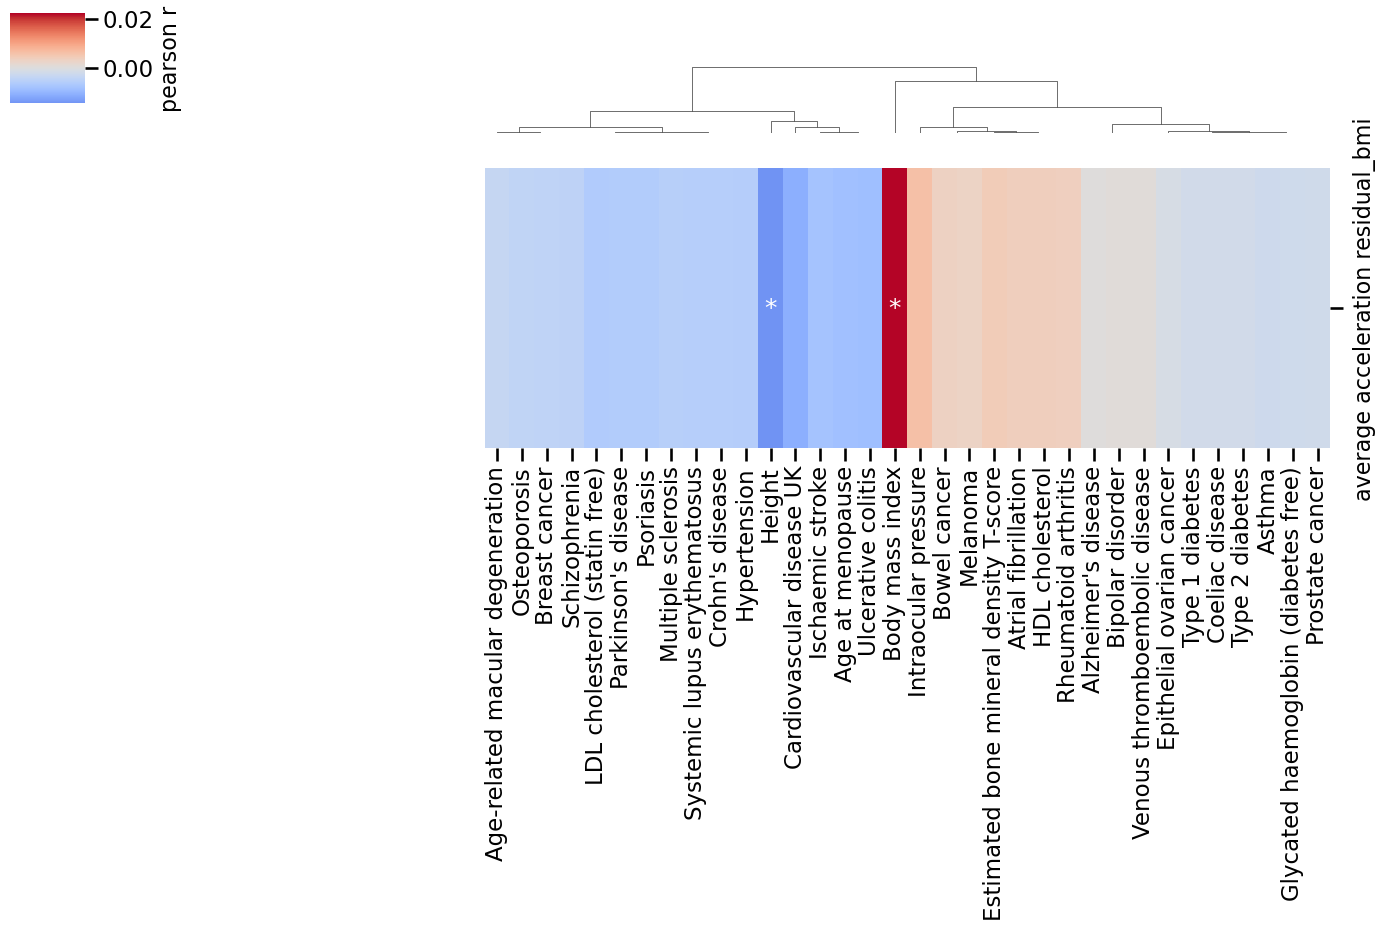

In [123]:
for y,kind in zip(['average acceleration residual_bmi'],['resbmi']):
    rvalues = pd.DataFrame(index=traits.loc['full_name'],
                       columns=['r','p'])
    for disease in traits.loc['full_name']:
        nona = alle.dropna(subset=[y,disease])# or only hc
        print(nona.shape)
        rv, pv = stats.pearsonr(nona[disease],nona[y])
        rvalues.loc[disease,'r'] = rv
        rvalues.loc[disease,'p'] = pv
        rvalues.loc[disease,'s'] = rvalues.loc[disease,'p'] < (0.05/rvalues.shape[0])
    rvalues['s'] = rvalues['s'].replace([True,False],['*',''])
    plots.plot_context()
    g = sns.clustermap(rvalues[['r']].astype(float).T,annot=rvalues[['s']].T,cmap='coolwarm',center=0,fmt='',
                  figsize=(15,5),cbar_kws={'label': 'pearson r'},row_cluster=False,method='ward',xticklabels=True)
    ax = g.ax_heatmap
    ax.set_xlabel('');
    ax.set_ylabel(y)
    ax.set_yticklabels('')
    #plt.savefig(f'{image_path}/PRS_clustermap_acc{kind}_pearson.pdf',bbox_inches='tight',dpi=200)